## Importing...

In [4]:
import itertools
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers, models, metrics
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from parameters import *
from dataProcessing import *
from dataVisualizing import *

# ---------------------------------------------------------------------------------------------------------------------------------------------------

## Models define (3)

In [5]:
def constructDLModel(featureColumns=["Open", "High", "Low", "Close"], numOfPastDays=50, numOfFutureDays=1, layersNumber=2, layerSize=256, layerName=layers.LSTM, 
                     dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    # Check if the layersNumber >= 1
    if (layersNumber < 1):
        raise ValueError("Number of layers should be equal to or more than 1")

    # Initialize a Sequential model
    model = models.Sequential()    

    for i in range(layersNumber):
        # First Layer
        if (i == 0):
            if (bidirectional):
                model.add(layers.Bidirectional(layerName(units=layerSize, return_sequences=True), input_shape=(numOfPastDays, len(featureColumns))))
            else:
                model.add(layerName(units=layerSize, return_sequences=True, input_shape=(numOfPastDays, len(featureColumns))))
        # Last layer
        elif (i == layersNumber - 1):
            if (bidirectional):
                model.add(layers.Bidirectional(layerName(units=layerSize, return_sequences=False)))
            else:
                model.add(layerName(units=layerSize, return_sequences=False))
        # Other layers
        else:
            if (bidirectional):
                model.add(layers.Bidirectional(layerName(units=layerSize, return_sequences=True)))
            else:
                model.add(layerName(units=layerSize, return_sequences=True))
                
        # Add Dropout after each layer
        model.add(layers.Dropout(dropout))
    
    # Add Dense output layer (with <NUMBER_OF_FUTURE_DAYS> neuron (unit))
    model.add(layers.Dense(numOfFutureDays))
        
    # Compile the model (with loss function, evaluation metric (mean_absolute_error), and optimizer)
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.MeanAbsoluteError()])
    
    return model

# ---------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# TEST MACHINE LEARNING MODEL - MULTIVARIATE PROBLEM 
def trainAndTestMultivariateDLModel(processedData, featureColumns=["Open", "High", "Low", "Close"], numOfPastDays=50, numOfFutureDays=1, layersNumber=2, layerSize=256, layerName=layers.LSTM, 
                                 dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False,
                                 epochs=50, batchSize=32):
    # Training
    #   Check if the model's folder is exist
    if (not os.path.isdir("models")):
        os.mkdir("models")  
        
    modelFilePath = "models/{}-fCols_{}-pDays_{}-fdays_{}-layers_{}-lSize_{}-lName_{}-do_{}-loss_{}-optimizer_{}biD_{}-epochs_{}-bSize.keras".format(len(featureColumns), numOfPastDays, numOfFutureDays, layersNumber, 
                                                                                                                     layerSize, str(layerName).split('.')[-1].split("'")[0], 
                                                                                                                     dropout, loss, optimizer, bidirectional, epochs, batchSize)

    if (not os.path.exists(modelFilePath)):        
        # Create and train the Deep Learning model
        model = constructDLModel(featureColumns=featureColumns, numOfPastDays=numOfPastDays, numOfFutureDays=numOfFutureDays, layersNumber=layersNumber, layerSize=layerSize, layerName=layerName, 
                                 dropout=dropout, loss=loss, optimizer=optimizer, bidirectional=bidirectional)

        model.fit(x=processedData["XTrain"], y=processedData["YTrain"], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(processedData["XTest"], processedData["YTest"]))
        
        # Save the model
        model.save(modelFilePath)
        print("Trained model saved to {}".format(modelFilePath))
    else:
        # Load the model
        model = models.load_model(modelFilePath)
        print("Trained model loaded from {}".format(modelFilePath))
        
    # Testing
    #   Get actual and predicted data
    yActualData = processedData["YTest"]
    yPredictedData = model.predict(processedData["XTest"])

    #   Descale
    if (IS_SCALED_DATA):
        yActualData = np.squeeze(processedData["ColumnScalers"]["Close"].inverse_transform(yActualData))
        yPredictedData = np.squeeze(processedData["ColumnScalers"]["Close"].inverse_transform(yPredictedData))
        
    #print("================ Y-ACTUAL DATA ===================")
    #print(yActualData)
    #print("=============== Y-PREDICTED DATA =================")   
    #print(yPredictedData)
  
    #   Plot
    plotSingleFeature("{} Close Price Multivariate Prediction", yActualData, yPredictedData)
    #MSE
    mse = mean_squared_error(yPredictedData,  yActualData)
    print("Mean Squared Error:", mse)
    #MAPE
    mape = mean_absolute_percentage_error(yPredictedData,  yActualData)
    print("Mean Absolute Percentage Error:", mape)
    
    
    return (yActualData, yPredictedData)

# ---------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# TEST MACHINE LEARNING MODEL - ARIMA
def createARIMAModel(processedData):
    data = processedData["XTest"]
    actualData = processedData["YTest"]

    # Check if the model's folder is exist
    if (not os.path.isdir("models")):
        os.mkdir("models")     

    # Get the close data
    singleFeatureData = []
    for i in range(0, len(data)):
        singleFeatureSequence = []
        for sequence in data[i]:
            singleFeatureSequence.append(sequence[2])

        singleFeatureData.append(singleFeatureSequence)
        
    singleFeatureData = np.array(singleFeatureData)
        
    # Make sure the data become stationary
    singleFeatureStationaryData = []
    for singleFeatureSequence in singleFeatureData:
        singleFeatureStationaryData.append(makeStationaryData(data=singleFeatureSequence))
        
    singleFeatureStationaryData = np.array(singleFeatureStationaryData)

    predictedData = []

    # Create and fit ARIMA models
    for i in range(0, len(singleFeatureStationaryData)):
        modelFilePath = "models/{}-type_{}-company_{}-feature_{}-traingDataShape_{}-index.pkl".format("ARIMA", COMPANY, "Close", data.shape, i)        

        if (not os.path.exists(modelFilePath)):
            # Find the best parameters for the model for each sequence
            model = auto_arima(singleFeatureStationaryData[i], start_p=0, start_q=0, test="adf", max_p=7, max_q=7,
                               m=1, d=None, seasonal=False, start_P=0, D=0, trace=True,
                               error_action="ignore", suppress_warnings=True, stepwise=True)
        
            bestOrder = model.order
            bestSeasonalOrder = model.seasonal_order
        
            # Create model for each sequence
            model = ARIMA(singleFeatureStationaryData[i], order=bestOrder, seasonal_order=bestSeasonalOrder)
            # Fit the model
            fittedModel = model.fit()
            # Save the model
            fittedModel.save(modelFilePath)
            #print("ARIMA model saved.")
        else:
            # Load the model
            fittedModel = ARIMAResults.load(modelFilePath)
            #print("ARIMA model loaded.")  
        
        # Predict the data
        (forecastData, standardErrors, confidenceIntervals) = fittedModel.forecast(3, alpha=0.05)
        
        predictedData.append(forecastData)
       
    predictedData = np.array(predictedData)
    
    # Descale data
    actualData = np.squeeze(processedData["ColumnScalers"]["Close"].inverse_transform(actualData))
    predictedData = np.squeeze(processedData["ColumnScalers"]["Close"].inverse_transform(np.expand_dims(predictedData, axis=0)))
    
    #print("=================== ACTUAL DATA ==================")
    #print(actualData)
    #print("================= PREDICTED DATA =================")
    #print(predictedData)
    
    # Plot data
    plotSingleFeature("{} Close Price Prediction with ARIMA model".format(COMPANY), actualData, predictedData)
     #MSE
    mse = mean_squared_error(predictedData,  actualData)
    print("Mean Squared Error:", mse)
     #MAPE
    mape = mean_absolute_percentage_error(predictedData,  actualData)
    print("Mean Absolute Percentage Error:", mape)

    return (actualData, predictedData)
    
def makeStationaryData(data):
    stationaryData = data    

    aDFResult = adfuller(data, autolag="AIC")
    
    if (aDFResult[1] >= 0.05):
        dataLog = np.log(data)
        dataLog = pd.DataFrame(dataLog)
        movingAverage = dataLog.rolling(window=12).mean()
        dataLogMinusMean = dataLog - movingAverage
        dataLogMinusMean.ffill(inplace=True) 
        
    return stationaryData
    

processedData = processData(isStoredDataLocally=True, company=COMPANY, startDate=START_DATE, endDate=END_DATE, dataSource=DATA_SOURCE, 
                            numOfPastDays=NUMBER_OF_PAST_DAYS, numOfFutureDays=NUMBER_OF_FUTURE_DAYS, lookupSteps=LOOKUP_STEPS, featureColumns=FEATURE_COLUMNS,
                            trainRatio=TRAIN_RATIO, randomSplit=False, randomSeed=None, isScaledData=IS_SCALED_DATA, featureRange=(0, 1), isStoredScaler=True)

# ---------------------------------------------------------------------------------------------------------------------------------------------------

Loaded data from the saved file
Loaded scaler.
Scaled data.
Loaded scaler.
Scaled data.
Loaded scaler.
Scaled data.
Loaded scaler.
Scaled data.


## Trained models results

Trained model loaded from models/4-fCols_60-pDays_1-fdays_2-layers_64-lSize_GRU-lName_0.3-do_mean_squared_error-loss_adam-optimizer_FalsebiD_100-epochs_32-bSize.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


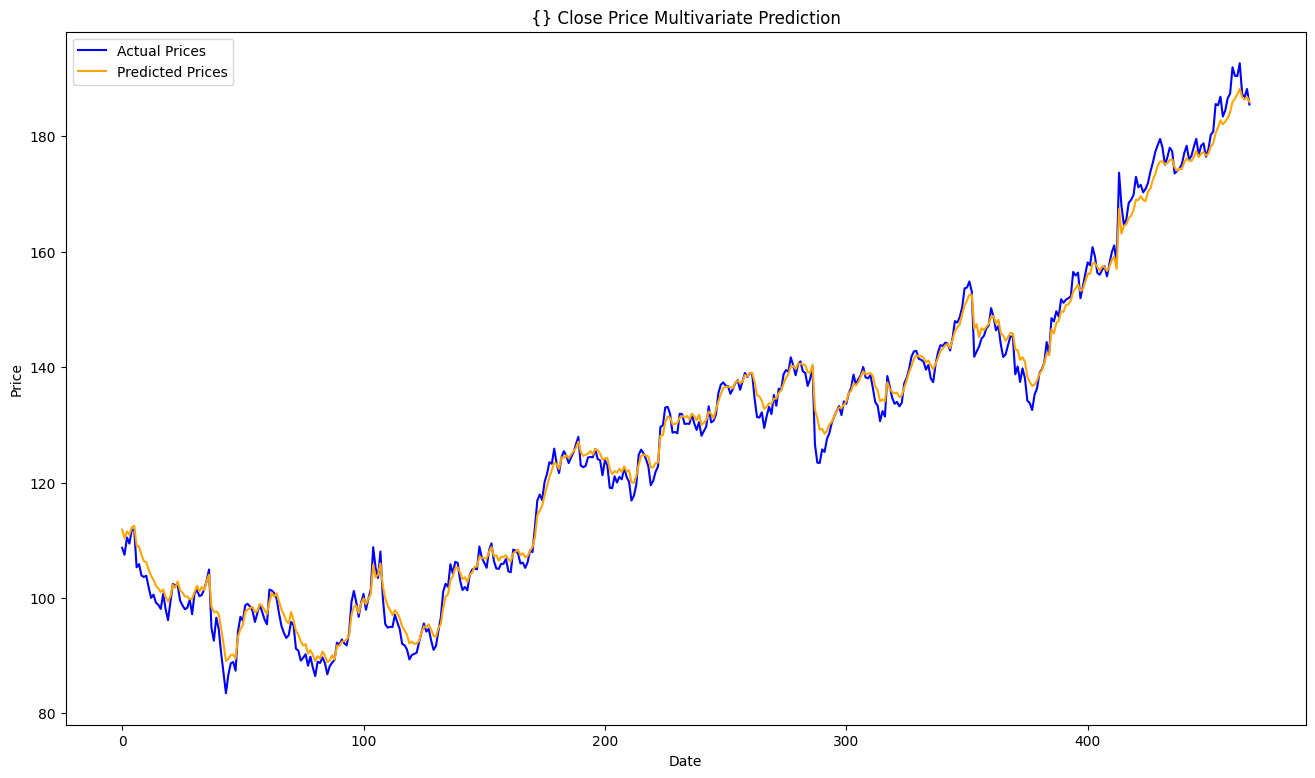

Mean Squared Error: 3.946707239703494
Mean Absolute Percentage Error: 1.285232333537281


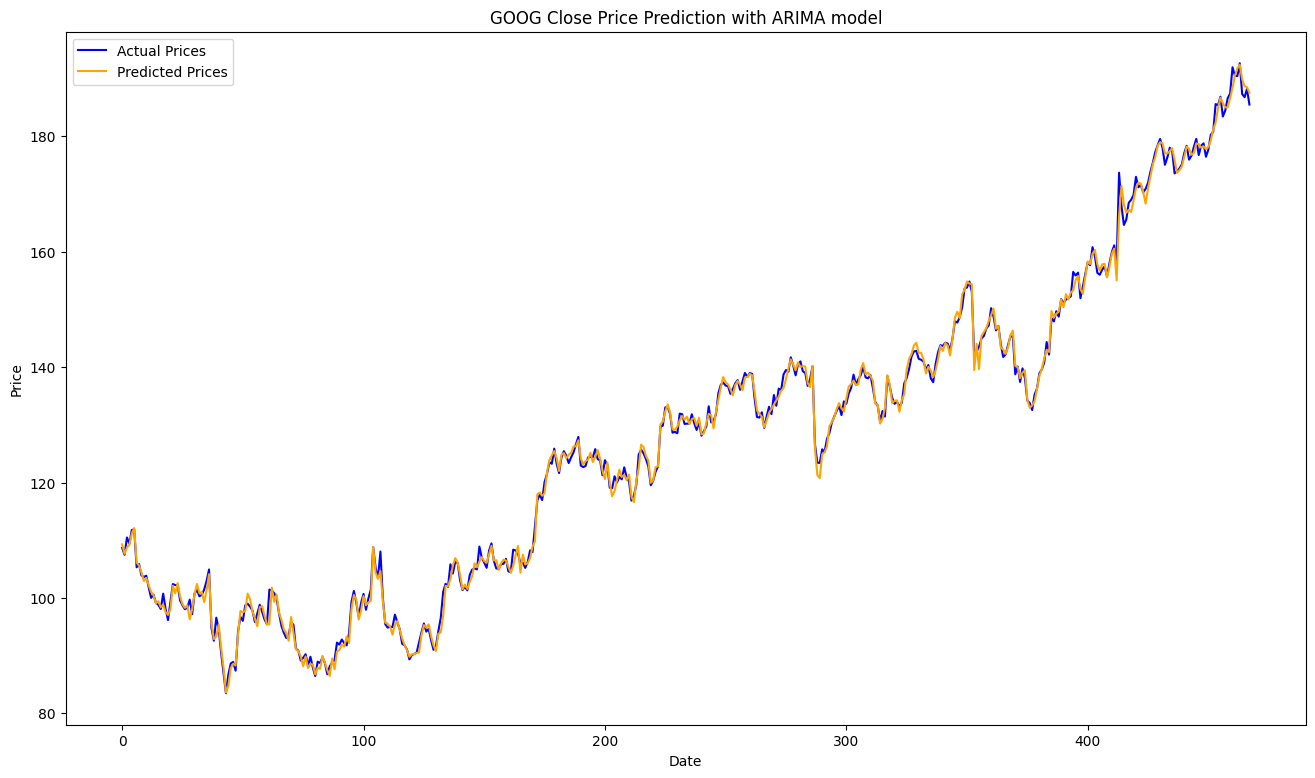

Mean Squared Error: 1.4533206897395168
Mean Absolute Percentage Error: 0.7220570837914522


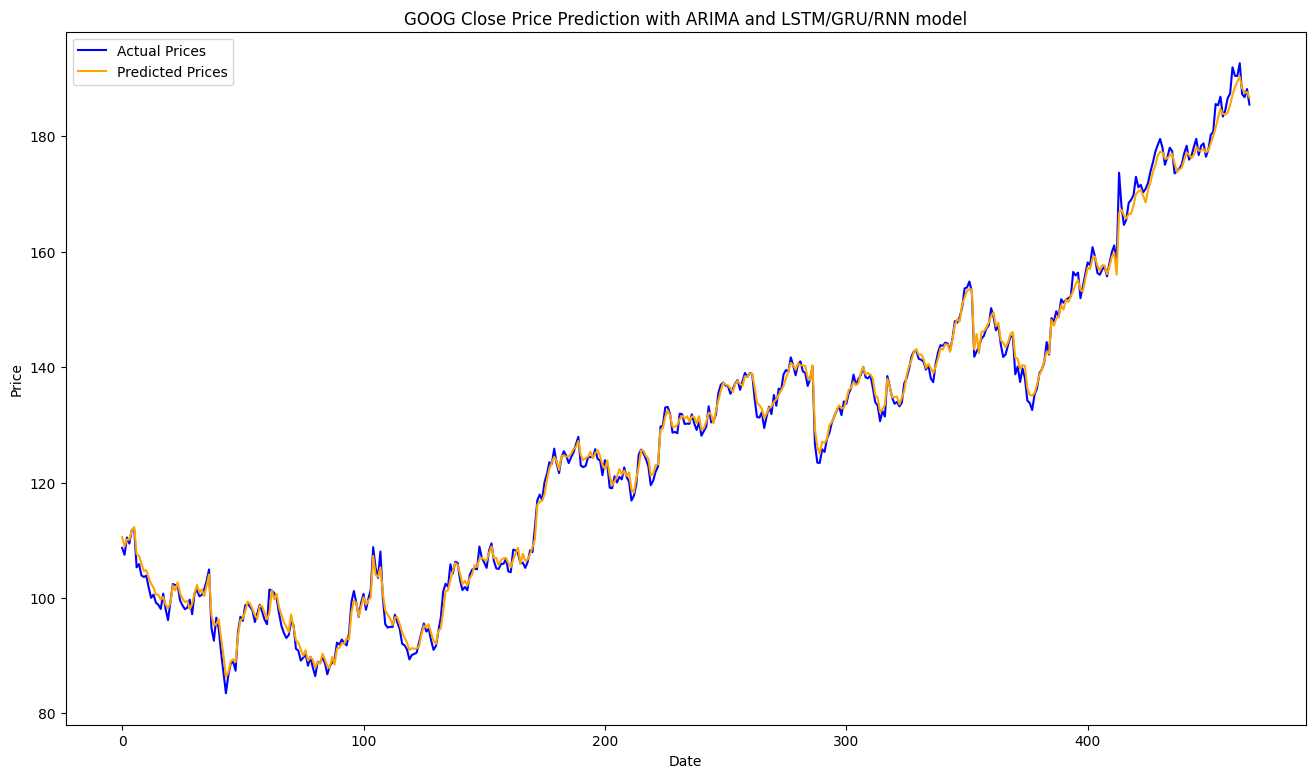

Mean Squared Error: 1.6370992078993978
Mean Absolute Percentage Error: 0.8284795831298877


In [8]:
# TEST MACHINE LEARNING MODEL - ARIMA AND LSTM/GRU/RNN

# LSTM/GRU/RNN
(firstYActualData, firstYPredictedData) = trainAndTestMultivariateDLModel(processedData=processedData, featureColumns=FEATURE_COLUMNS, 
                                                                          numOfPastDays=NUMBER_OF_PAST_DAYS, numOfFutureDays=NUMBER_OF_FUTURE_DAYS, 
                                                                          layersNumber=LAYERS_NUMBER, layerSize=LAYER_SIZE, layerName=LAYER_NAME, 
                                                                          dropout=DROPOUT, loss=LOSS, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL,
                                                                          epochs=EPOCHS, batchSize=BATCH_SIZE)


# ARIMA
(thirdYActualData, thirdYPredictedData) = createARIMAModel(processedData)

# Averaging outputs
(finalYActualData, finalYPredictedData) = ([], [])

for i in range(0, min(len(firstYPredictedData), len(thirdYPredictedData))):
    finalYActualData.append((firstYActualData[i] + thirdYActualData[i]) / 2)
    finalYPredictedData.append((firstYPredictedData[i] + thirdYPredictedData[i]) / 2)
#   Plot data
plotSingleFeature("{} Close Price Prediction with ARIMA and LSTM/GRU/RNN model".format(COMPANY), finalYActualData, finalYPredictedData)
 #MSE
mse = mean_squared_error( finalYPredictedData,   finalYActualData)
print("Mean Squared Error:", mse)
#MAPE
mape = mean_absolute_percentage_error( finalYPredictedData,   finalYActualData)
print("Mean Absolute Percentage Error:", mape)




### Support Vector Machines

Loaded data from the saved file


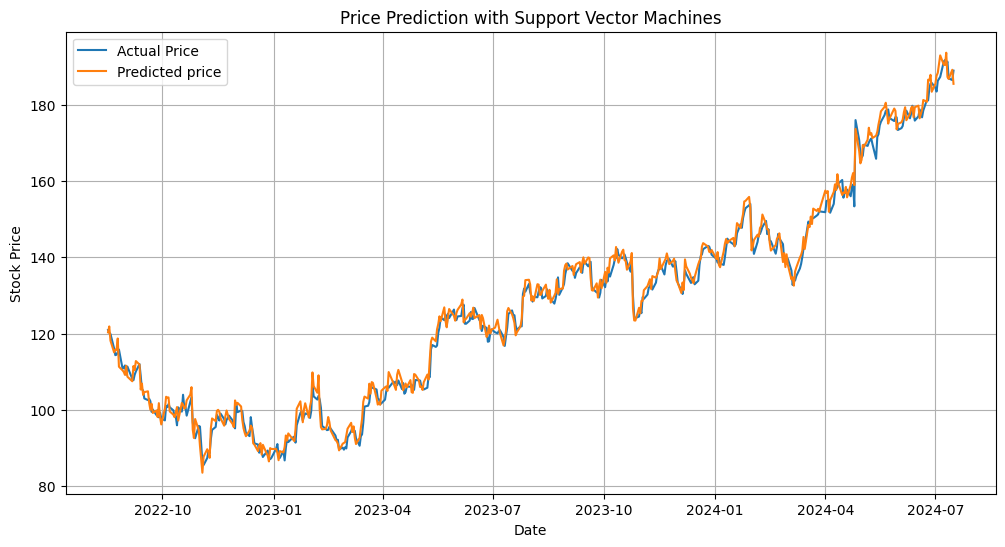

Mean Squared Error: 5.281183382930858
Mean Absolute Percentage Error: 1.6089386703937796


In [14]:
# SVMs model test 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 
  
# For data manipulation 
import pandas as pd 
import numpy as np 
  
# To plot 
import matplotlib.pyplot as plt 
#plt.style.use('seaborn-darkgrid') 
  
# To ignore warnings 
import warnings 
warnings.filterwarnings("ignore")
#Others imports
import os
from dataProcessing import *
from parameters import *
#-----------------------------------------------------------------------------------------
# LOAD DATA
dataFileName = "{}-company_{}-type_{}-startD_{}-endD".format(COMPANY, "data",START_DATE, END_DATE)
dataFilePath = "stockdatas/{}.csv".format(dataFileName)

if (os.path.exists(dataFilePath)):
    df = pd.read_csv(dataFilePath, index_col=0, parse_dates=True)
    print("Loaded data from the saved file")

 # Add date as a column
if ("Date" not in df.columns):
    df["Date"] = df.index
#df = pd.read_csv('company.csv') #_______________________

# Calculate daily change
df['Change'] = df['Close'] - df['Open']

# Predict Close price movement (Up or Down) based on change
y = np.where(df['Change'] > 0, 1, 0)  # 1 for Up, 0 for Down

# Create predictor variable based on Open-Close difference
X = df[['Change']]

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(df))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Train the SVM model
svm_model = SVC().fit(X_train, y_train)

# Predict Close price movement for test data
predicted_change = svm_model.predict(X_test)

# Calculate predicted open prices based on predicted change and actual close prices
predicted_open = df['Close'].iloc[split_index:] + predicted_change

# Plot actual vs predicted Open prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[split_index:], df['Open'].iloc[split_index:], label='Actual Price')
plt.plot(df['Date'].iloc[split_index:], predicted_open, label='Predicted price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Price Prediction with Support Vector Machines')
plt.legend()
plt.grid(True)
plt.show()
#---------------------------
 #MSE
mse = mean_squared_error( predicted_open, df['Open'].iloc[split_index:])
print("Mean Squared Error:", mse)
#MAPE
mape = mean_absolute_percentage_error( predicted_open, df['Open'].iloc[split_index:])
print("Mean Absolute Percentage Error:", mape)

Loaded data from the saved file


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 100, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 100, 1)            │               2 │ input_layer_1[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 100, 1)            │           7,169 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 100, 1)            │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 100, 1)            │               0 │ dropout_5[0][0],           │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 100, 1)            │               2 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 100, 4)            │               8 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 100, 4)            │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 100, 1)            │               5 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 100, 1)            │               0 │ dense_5[0][0], add_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_1    │ (None, 100)               │               0 │ add_3[0][0]                │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 100)               │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 20)                │           2,020 │ dropout_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1)                 │              21 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 392ms/step - loss: 0.1881 - val_loss: 0.2183
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - loss: 0.0377 - val_loss: 0.0797
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - loss: 0.0054 - val_loss: 0.0108
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - loss: 0.0030 - val_loss: 0.0169
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.0026 - val_loss: 0.0175
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - loss: 0.0026 - val_loss: 0.0145
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - loss: 0.0023 - val_loss: 0.0142
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - loss: 0.0020 - val_loss: 0.0102
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - loss: 0.0020 - val_loss: 0.0141
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - loss: 0.0018 - val_loss: 0.0099
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/ste

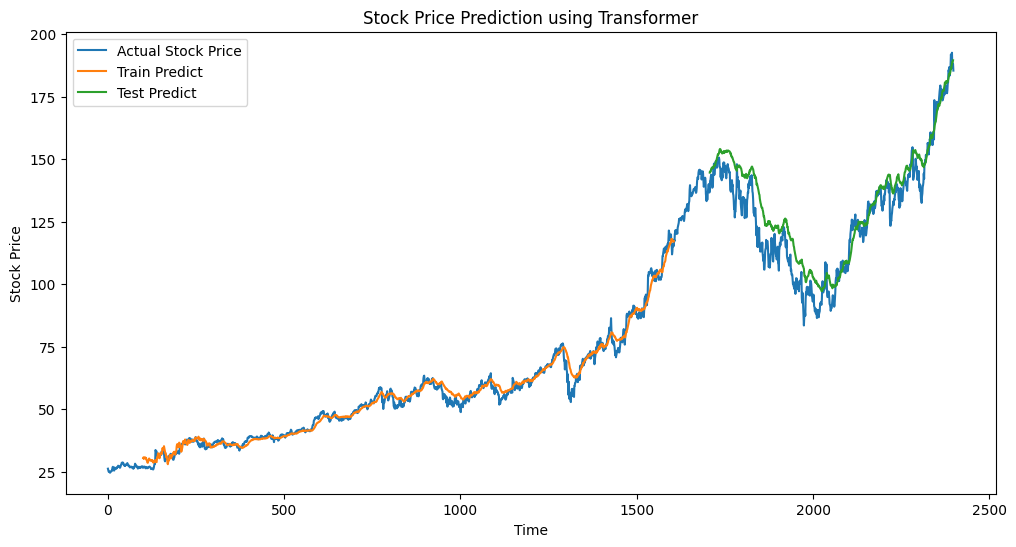

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

#other import
import os
from dataProcessing import *
from parameters import *
import warnings 
warnings.filterwarnings("ignore")

# Load and prepare the dataset
# LOAD DATA
dataFileName = "{}-company_{}-type_{}-startD_{}-endD".format(COMPANY, "data",START_DATE, END_DATE)
dataFilePath = "stockdatas/{}.csv".format(dataFileName)

if (os.path.exists(dataFilePath)):
    df = pd.read_csv(dataFilePath, index_col=0, parse_dates=True)
    print("Loaded data from the saved file")

 # Add date as a column
if ("Date" not in df.columns):
    df["Date"] = df.index
data = df[['Close']].values
#-------------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluate the model (Optional: Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train, scaler.inverse_transform(train_predict.reshape(-1, 1))))
test_rmse = math.sqrt(mean_squared_error(y_test, scaler.inverse_transform(test_predict.reshape(-1, 1))))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
#du lieu 10 cong ty 
#visual 
#chi so danh gia (MSE, MAPE) 
#chon 1 model moi 